In [4]:
import os
import gc
import time
import copy
import json
import random
import pathlib
import argparse
import math as m
import matplotlib
import numpy as np
from typing import Tuple
from random import randrange

from segysak.segy import segy_loader
from source.enum_types import DatasetType, DataType
from source.pre_process  import create_dataset, dataset_test_creator, predict
from source.callbacks import cosine_schedule, TrainMonitor, weighted_categorical_crossentropy, calculate_weight_distribution

from src_3D.DataLoader import DataLoader
from src_3D.DatasetCreator import DatasetCreator
from src_3D.AlineDatasetReader import AlineDatasetReader


import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

from conf.config import Configuration
from hydra.core.config_store import ConfigStore
from hydra import compose, initialize
from omegaconf import OmegaConf

os.environ["CUDA_VISIBLE_DEVICES"]="2"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[255] = [0., 0., 1., 1.]
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='filter',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [1., 0., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='label',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 1., 0., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cpixel',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

color_array[255] = [0., 0., 1., 1.]
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='cblue',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

/tmp/ipykernel_31906/4210114844.py:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_31906/4210114844.py:19: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_31906/4210114844.py:26: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)
/tmp/ipykernel_31906/4210114844.py:32: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.reg

In [6]:
cs = ConfigStore.instance()
cs.store(name='execution_config', node=Configuration)

initialize(config_path="conf")
cfg = compose(config_name="config.yaml")

print(OmegaConf.to_yaml(cfg))

roi_config:
  roi_size: 200
  n_spacing_pixels_roi: 30
  roi_separation_in_percentage: 0.3
  n_traces_block: 1
  random_displacement: true
model_config:
  n_epochs: 150
  n_units_lstm_layers:
  - 256
  - 128
  - 64
  n_filters_dcunet: 64
  learning_rate: 0.0001
  batch_size: 1000
  SHUFFLE_BUFFER_SIZE: 1000
  concatenate_train_val_sequences: true
  validation_split_proportion: 0.35
  augmentation: true
  cross_validation_folds: null
regularexpression:
  expr_regular_match_filenames_2d: (([0-9]{4}\-[0-9]{4})(_ANP|ANP|_Ext|Ext|_E|E|_A|A|_CPGEO|CPGEO|(_{1}[0-9]+)*)?)
  expr_regular_match_filenames_3d_sgy: ([0-9A-Za-z_]+)(.sgy)
  expr_regular_match_filenames_3d_json: ([0-9A-Za-z_]+)-([A-za-z_]+).json
gas_config:
  n_spacing_pixels_gas: 10
seed_config:
  SEED: 123
file_path_config:
  base_dir: ''
  train_json: ''
  campos_base_dir: null
output_paths:
  tensorboard: Teste_Locations_BL102
  out_directory: Teste_Locations_BL102



/tmp/ipykernel_31906/758786265.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")
/local/lsantos/.conda/envs/alineGPT/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [1]:
def load_data(json_path, 
              cfg
             ):
    
    train_3d_json = json_path
    base_dir = cfg.file_config.base_dir
    #seed_everything(cfg.seed_config.SEED)
    aline_data_reader = AlineDatasetReader()
    training_paths = aline_data_reader.read_dataset_file(dataset_file=train_3d_json, base_dir=base_dir)

    data_loader_3d = DataLoader(dataset_type=enum_types.DatasetType.TRAIN,
                                data_type=enum_types.DataType.DATA_3D,
                                data_paths=training_paths,
                                config=cfg)

    train_data, val_data, test_data = data_loader_3d.data_list


    return (train_data, val_data, test_data)

In [10]:
cfg.train_config.batch_size = 200
cfg.roi_config.roi_size = 250

dataset = ['gvp', 'gvca', 'gvbl']
dataset_name = dataset[1]

### Load Data

In [14]:
data_reader = DatasetReader()

training_paths = data_reader.read_dataset_file(
    dataset_file= 'json_files/' + dataset_name  +  '.json', base_dir='',
)

data_loader_2d = DataLoader(
        dataset_type=DatasetType.TRAIN,
        data_type=DataType.DATA_2D,
        data_paths=training_paths,
        config=cfg,
    )

train_data, val_data, test_data = data_loader_2d.data_list

dataset_creator = DatasetCreator(
    batch_size=cfg.model_config.batch_size,
    config=cfg,
    shuffle=True,
    reshuffle_each_iteration=True,
)

print('Seismics Loaded for TRAIN:')

train_data_samples = dataset_creator.build_samples(
    views_2d=train_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)
print('Seismics Loaded for VALIDATION:')

val_data_samples = dataset_creator.build_samples(
    views_2d=val_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)

print('Seismics Loaded for TEST:')

test_data_samples = dataset_creator.build_samples(
    views_2d=test_data,
    concat_axis=1,
    n_traces_block=cfg.roi_config.n_traces_block,
)

attrListTrain =[]
attrListVal = []
attrListTest = []

attrListTrain.append(train_data_samples)
attrListVal.append(val_data_samples)
attrListTest.append(test_data_samples)

x_train, y_train = create_dataset(attrListTrain)
x_val, y_val = create_dataset(attrListVal)
x_test, y_test = create_dataset(attrListTest)

x_train.astype(np.float32);
y_train.astype(np.float32);
x_val.astype(np.float32);
y_val.astype(np.float32);

NUMBER_SEQUENCES, TIME_STEPS, _ = x_train.shape
print('Numero de sequencias de treino: {}'.format(NUMBER_SEQUENCES)) 
    
print(np.amax(x_train))
print(np.mean(x_train))
print(np.std(x_train))

print(np.amax(x_val))
print(np.mean(x_val))
print(np.std(x_val))

print(np.amax(x_test))
print(np.mean(x_test))
print(np.std(x_test))

print(np.amin(x_train))
print(np.amin(x_val))
print(np.amin(x_test))

Loading 0375-1387: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.30it/s]


Seismics Loaded for TRAIN:
+----+----------------+---------------+
|    | Seismic id     |   Num Samples |
|----+----------------+---------------|
|  0 | 0303-0501      |          1045 |
|  0 | 0353-0005      |          5291 |
|  0 | 0375-1001      |          8169 |
|  0 | 0375-1004      |          1481 |
|  0 | 0375-1006      |          1545 |
|  0 | 0375-1007      |          1533 |
|  0 | 0375-1008      |          1388 |
|  0 | 0375-1009      |          1485 |
|  0 | 0375-1010      |          1425 |
|  0 | 0375-1011      |          1313 |
|  0 | 0375-1015      |          3393 |
|  0 | 0375-1116      |          1595 |
|  0 | 0375-1239_1343 |          2590 |
|  0 | 0375-1339      |          1713 |
|  0 | 0375-1342      |          2971 |
|  0 | 0375-1385      |           922 |
+----+----------------+---------------+
Seismics Loaded for VALIDATION:
+----+--------------+---------------+
|    | Seismic id   |   Num Samples |
|----+--------------+---------------|
|  0 | 0303-0491    |      

/local/lsantos/naturalGasDetection/source/pre_process.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traceList = list(map(lambda attr_pair: np.array(list(map(lambda attr: np.array([np.expand_dims(attr[:, idx], axis=1) for idx in range(attr.shape[1])]), attr_pair[0]))), balanced_attributes))
/local/lsantos/naturalGasDetection/source/pre_process.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  traceList = list(map(lambda attr_pair: np.array(list(map(lambda attr: np.array([attr[:, idx] for idx in range(attr.shape[1])]), attr_pair[1]))), balanc

Numero de sequencias de treino: 75718
7.677684
5.763509e-10
0.9999998
6.3452644
1.0863045e-09
0.9999999
5.4842687
2.6395857e-09
0.9999999
-5.948584
-5.309132
-5.279368


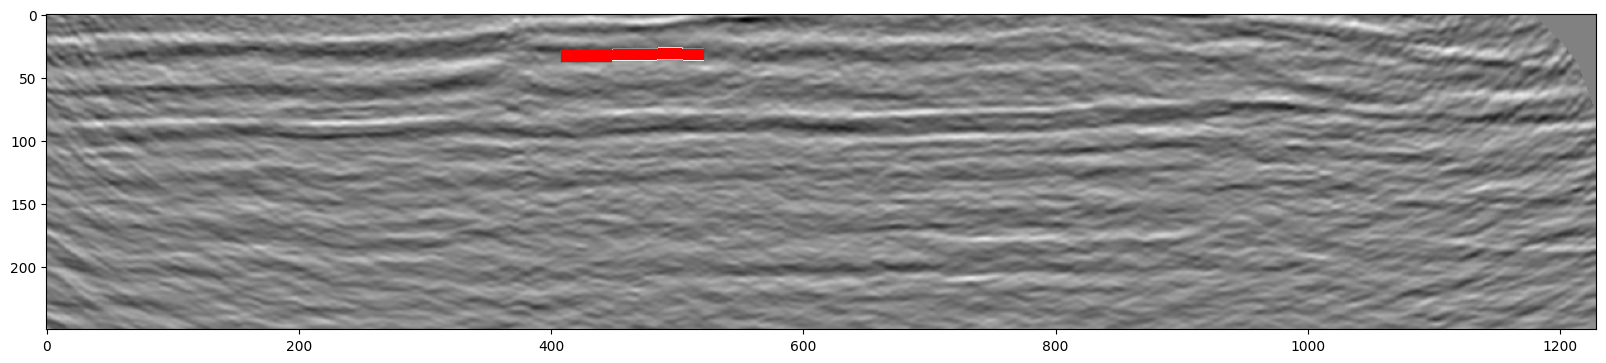

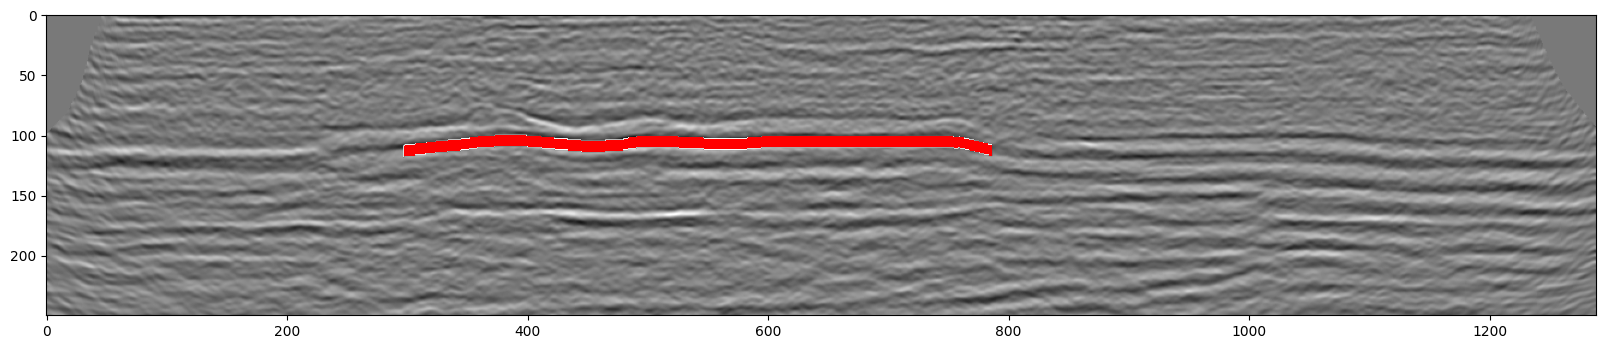

In [15]:
x_key1 = random.choice(list(val_data_samples.keys()))
x_key2 = random.choice(list(val_data_samples.keys()))

plt.figure(figsize = (20,20))
plt.imshow(val_data_samples[x_key1]['roi1'][0], cmap='gray')
plt.imshow(val_data_samples[x_key1]['roi1'][1], cmap='label')
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(val_data_samples[x_key2]['roi2'][0], cmap='gray')
plt.imshow(val_data_samples[x_key2]['roi2'][1], cmap='label')
plt.show()

In [16]:
def Encoder(embed_dim,
            num_heads,
            mlp_ratio,
            depth
           ):
    
    inputs = tf.keras.layers.Input((None, embed_dim))
    x = inputs
    for _ in range(depth):

        # Create a multi-head attention layer.  
        
        
        att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(embed_dim // num_heads), dropout=0.1
        )(x, x)
        
        

        # Skip connection 1.
        skip = x + att
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(skip)
        
        # Feed Forward Part
        x = tf.keras.layers.Dense(int(embed_dim*mlp_ratio), activation='gelu')(x)
        x = tf.keras.layers.Dense(embed_dim)(x)
        x = tf.keras.layers.Dropout(0.1)(x)

        # Skip connection 2.
        x = x + skip     
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        
        
    
    model = tf.keras.Model(inputs, x, name="encoder_block")
    
    return model


class AlineGPT(tf.keras.Model):

    
    def __init__(self, num_classes=2,
                 embed_dim=384, depth=3, num_heads=6,
                 mlp_ratio=4.,
                 dropout_rate=0.1,
                 batch_size=8):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = tf.keras.layers.Dense(embed_dim, activation='linear')

        
        model_enc =  Encoder(embed_dim,
                                num_heads,
                                mlp_ratio,
                                depth
                               )
        
        #model_enc.built = True 
        #model_enc.load_weights('weights/checkpoint2024-03-0015-20-03/checkpoint_test_encoder.h5')
        
        self.encoder = model_enc
        
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # Decoder specifics
        self.proj_layer = tf.keras.layers.Dense(512, activation='softmax')
        
        self.lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))
        self.lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))
        self.lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
        self.dropout_1 = tf.keras.layers.Dropout(rate=0.2)
        self.dropout_2 = tf.keras.layers.Dropout(rate=0.2)
        self.dropout_3 = tf.keras.layers.Dropout(rate=0.2)

        
        self.output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
        
        # --------------------------------------------------------------------------

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")


    def forward_encoder(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)

        return x

    def forward_decoder(self, x):
        x = self.proj_layer(x)
        x = self.lstm_1(x)
        x = self.dropout_1(x)
        x = self.lstm_2(x)
        x = self.dropout_2(x)
        x = self.lstm_3(x)
        x = self.dropout_3(x)
        
        x = self.output_layer(x)

        return x
    
    def compile(self, optimizer, loss_fn):
            super().compile()
            self.optimizer = optimizer
            self.loss_fn = loss_fn
            
    def train_step(self, data):
        X, Y = data
        with tf.GradientTape() as tape:
            
            latent = self.forward_encoder(X)
            pred = self.forward_decoder(latent)  # [N, L, p*p*3]
            
            loss = self.loss_fn(Y,
                                pred)
            
    
            # Apply gradients.
        train_vars = [
            self.encoder.trainable_variables, ## comment this line in case of finetuning
            self.lstm_1.trainable_variables,
            self.lstm_2.trainable_variables,
            self.lstm_3.trainable_variables,
            self.dropout_1.trainable_variables,
            self.dropout_2.trainable_variables,
            self.dropout_3.trainable_variables,
            self.patch_embed.trainable_variables,
            self.output_layer.trainable_variables,
            self.proj_layer.trainable_variables,
        ]
        
        
        grads = tape.gradient(loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.        
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        X, Y = data
        latent = self.forward_encoder(X)
        pred = self.forward_decoder(latent)  # [N, L, p*p*3]
            
        loss = self.loss_fn(Y,
                            pred)
        
        
        self.loss_tracker.update_state(loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"loss": self.loss_tracker.result()}

In [17]:
def model_train(x_train, y_train, x_val, y_val, sample_count, model,model_checkpoint_name, outdir, batch_size, attrList,  n_epochs=2000):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(outdir + '/' + model_checkpoint_name + ".cpk", 
                                               save_best_only=True, 
                                               save_weights_only=True, 
                                               monitor="val_loss", 
                                               verbose=1
                                            ),
        LearningRateScheduler(cosine_schedule(base_lr=1e-3, 
                                      total_steps=n_epochs, 
                                      warmup_steps=10))
       ,
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, mode='min'),
        TrainMonitor(attrList, 
                        epoch_interval=5
                       ),
    ]

    weight_class0, weight_class1 = calculate_weight_distribution(y_train, y_val)
    loss = weighted_categorical_crossentropy(np.array([weight_class0, weight_class1]))

    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss_fn=loss
    )
    
    #Transform labels to one hot encodind vectors
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

    #Concatenate train and validation sequences
    x_train = np.concatenate([x_train, x_val])
    y_train = np.concatenate([y_train, y_val])

    #Shuffle sequences
    idx = np.random.permutation(y_train.shape[0])
    x_train = x_train[idx]
    y_train = y_train[idx]
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    total_n_samples = tf.data.experimental.cardinality(train_dataset)
    validation_dataset = train_dataset.take(total_n_samples // 3)# 1 third to validation

    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.batch(batch_size)
    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

    train_dataset = train_dataset.prefetch(buffer_size=280)

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=n_epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

In [18]:
model = AlineGPT(num_classes=2,
                 embed_dim=192, 
                 depth=3,
                 mlp_ratio=4.,
                 num_heads=6
                )

2024-03-31 15:11:31.069449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6821 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:18:00.0, compute capability: 7.5


Weights (1.0066315044871466, 151.7953439431803)
Number of train batches: 462
Number of validation batches: 154


2024-03-31 15:11:35.128600: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 15:11:35.128648: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 15:11:35.128699: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 15:11:35.128738: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before

Epoch 1/2000


2024-03-31 15:11:35.880708: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 15:11:35.884085: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-31 15:11:43.820191: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-31 15:11:43.821590: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

462/462 [==============================] - ETA: 0s - loss: 3.8556
Epoch 1: val_loss improved from inf to 1.73623, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
(1497, 250)
(1497, 250)


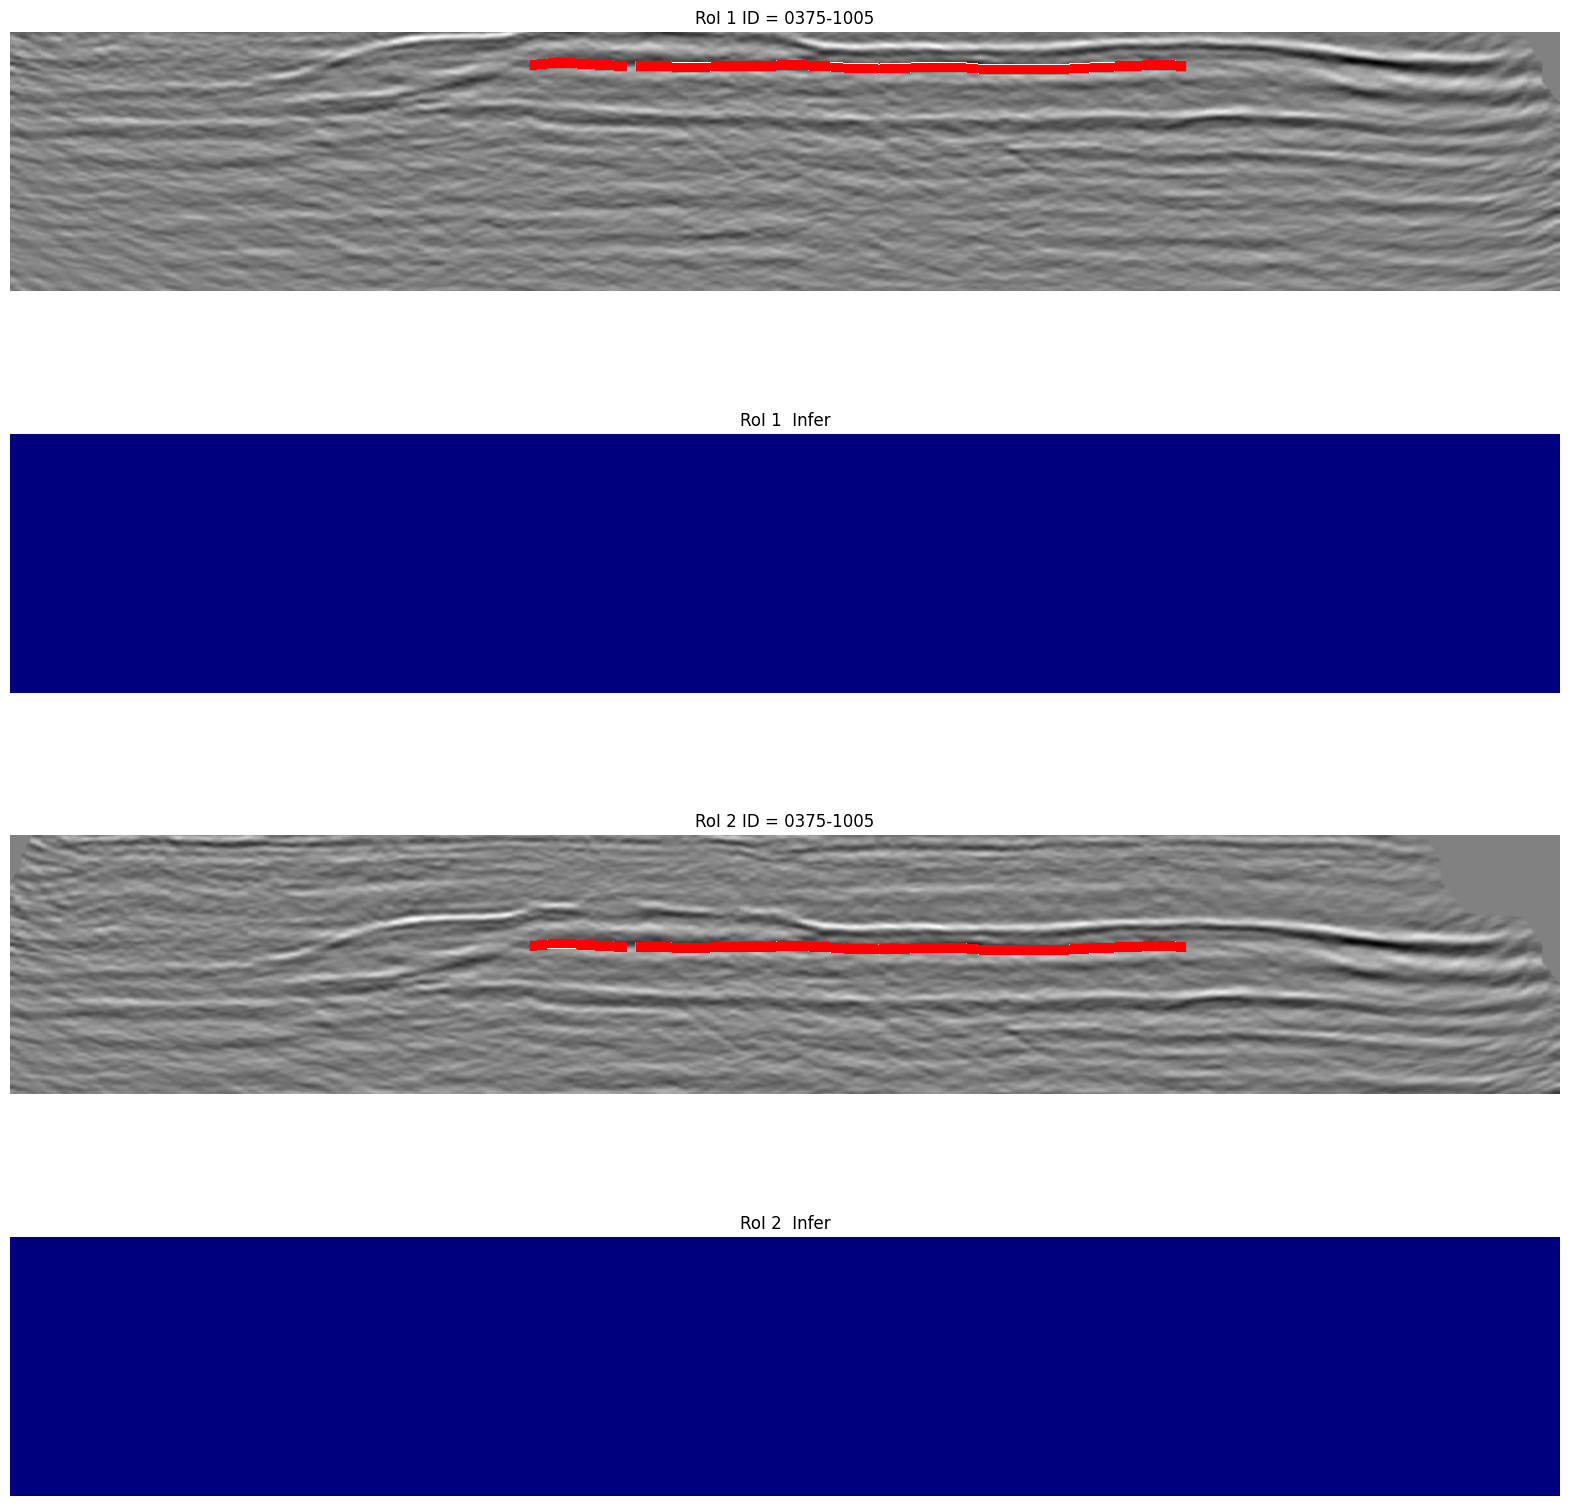

462/462 [==============================] - 249s 512ms/step - loss: 3.8556 - val_loss: 1.7362 - lr: 1.0000e-04
Epoch 2/2000
462/462 [==============================] - ETA: 0s - loss: 1.7173
Epoch 2: val_loss improved from 1.73623 to 1.55181, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 242s 519ms/step - loss: 1.7173 - val_loss: 1.5518 - lr: 2.0000e-04
Epoch 3/2000
462/462 [==============================] - ETA: 0s - loss: 1.5810
Epoch 3: val_loss improved from 1.55181 to 1.49361, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 240s 519ms/step - loss: 1.5810 - val_loss: 1.4936 - lr: 3.0000e-04
Epoch 4/2000
462/462 [==============================] - ETA: 0s - loss: 1.2801
Epoch 4: val_loss improved from 1.49361 to 1.26643, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33

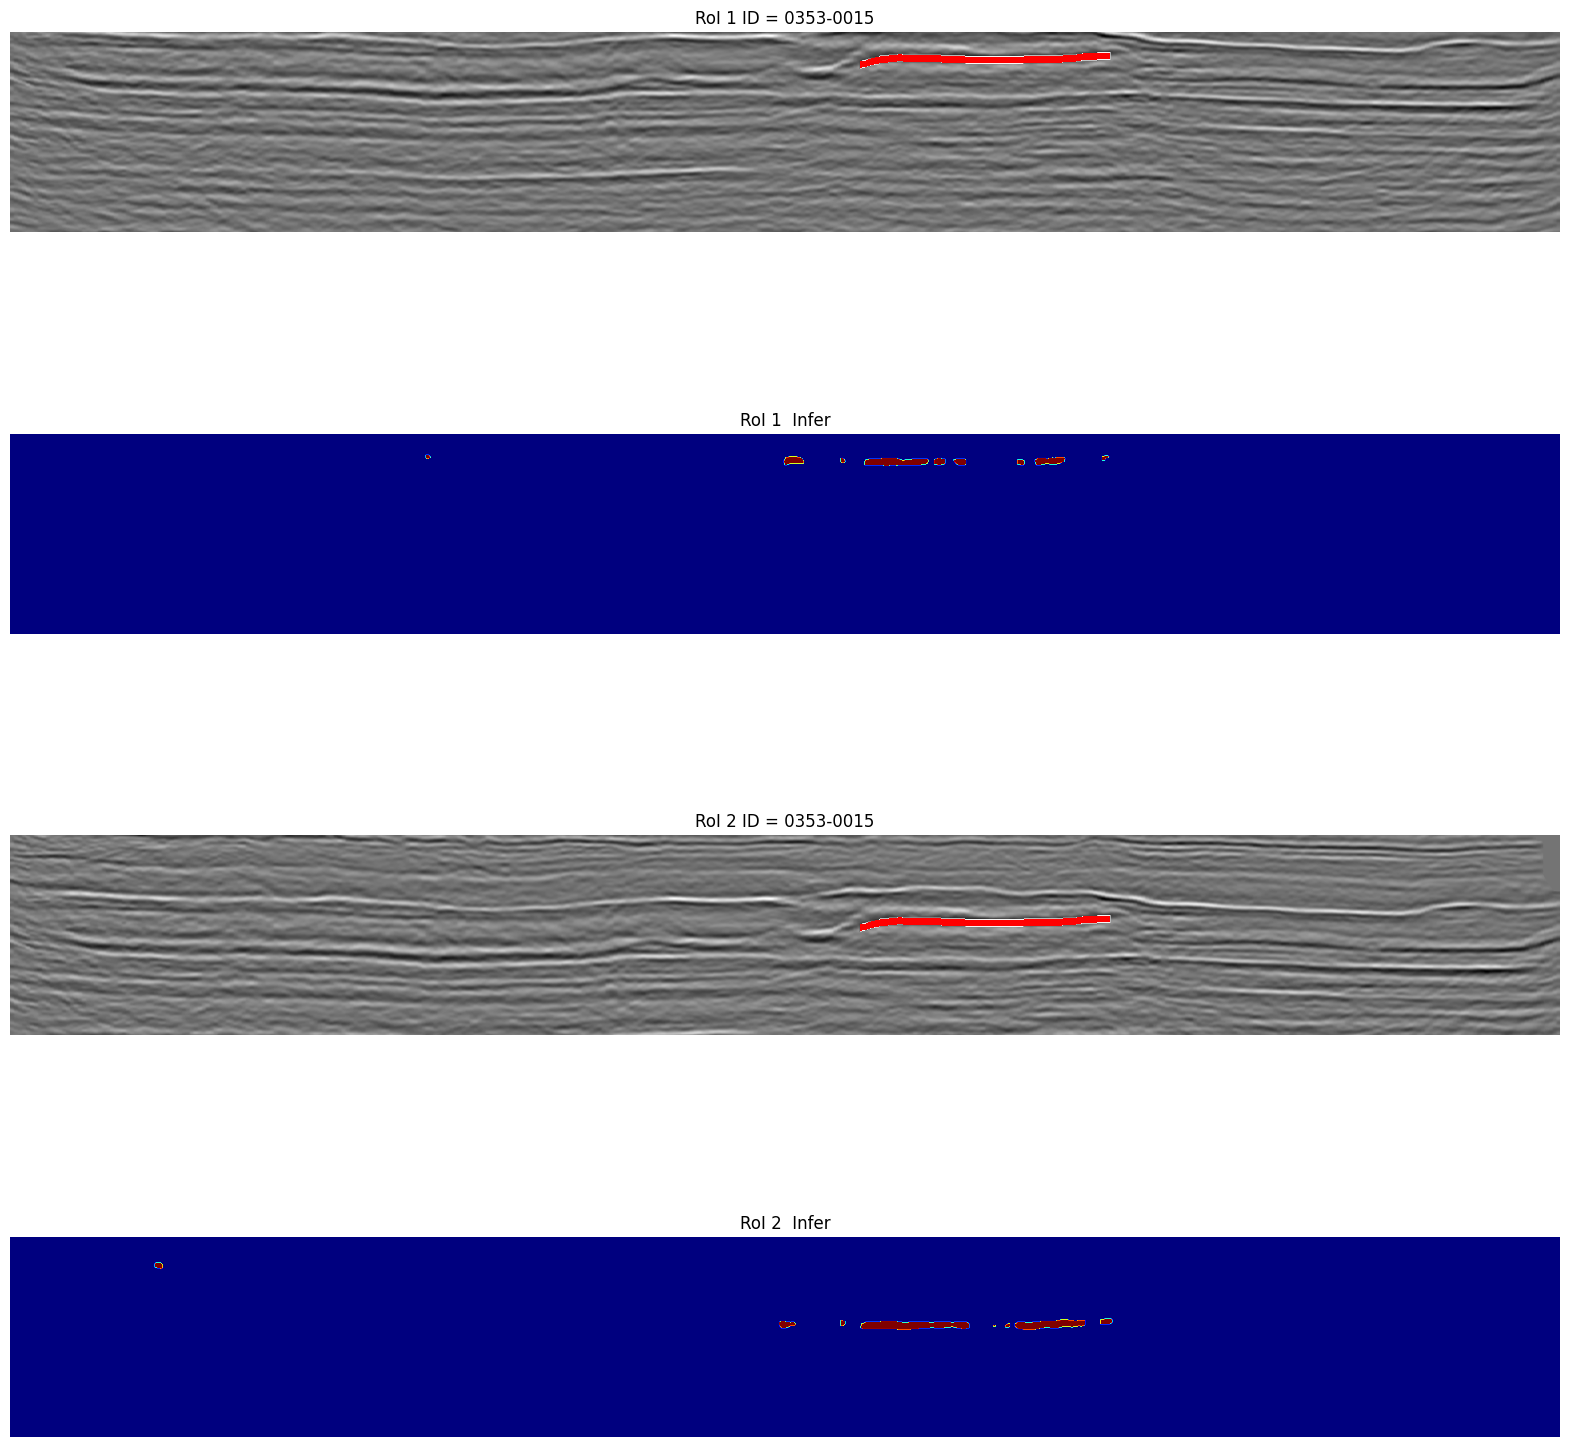

462/462 [==============================] - 246s 533ms/step - loss: 0.9099 - val_loss: 0.7291 - lr: 6.0000e-04
Epoch 7/2000
462/462 [==============================] - ETA: 0s - loss: 0.7545
Epoch 7: val_loss did not improve from 0.72911
462/462 [==============================] - 241s 517ms/step - loss: 0.7545 - val_loss: 0.7679 - lr: 7.0000e-04
Epoch 8/2000
462/462 [==============================] - ETA: 0s - loss: 0.6494
Epoch 8: val_loss improved from 0.72911 to 0.53943, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 239s 517ms/step - loss: 0.6494 - val_loss: 0.5394 - lr: 8.0000e-04
Epoch 9/2000
462/462 [==============================] - ETA: 0s - loss: 0.5542
Epoch 9: val_loss improved from 0.53943 to 0.53817, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 241s 522ms/step - loss:

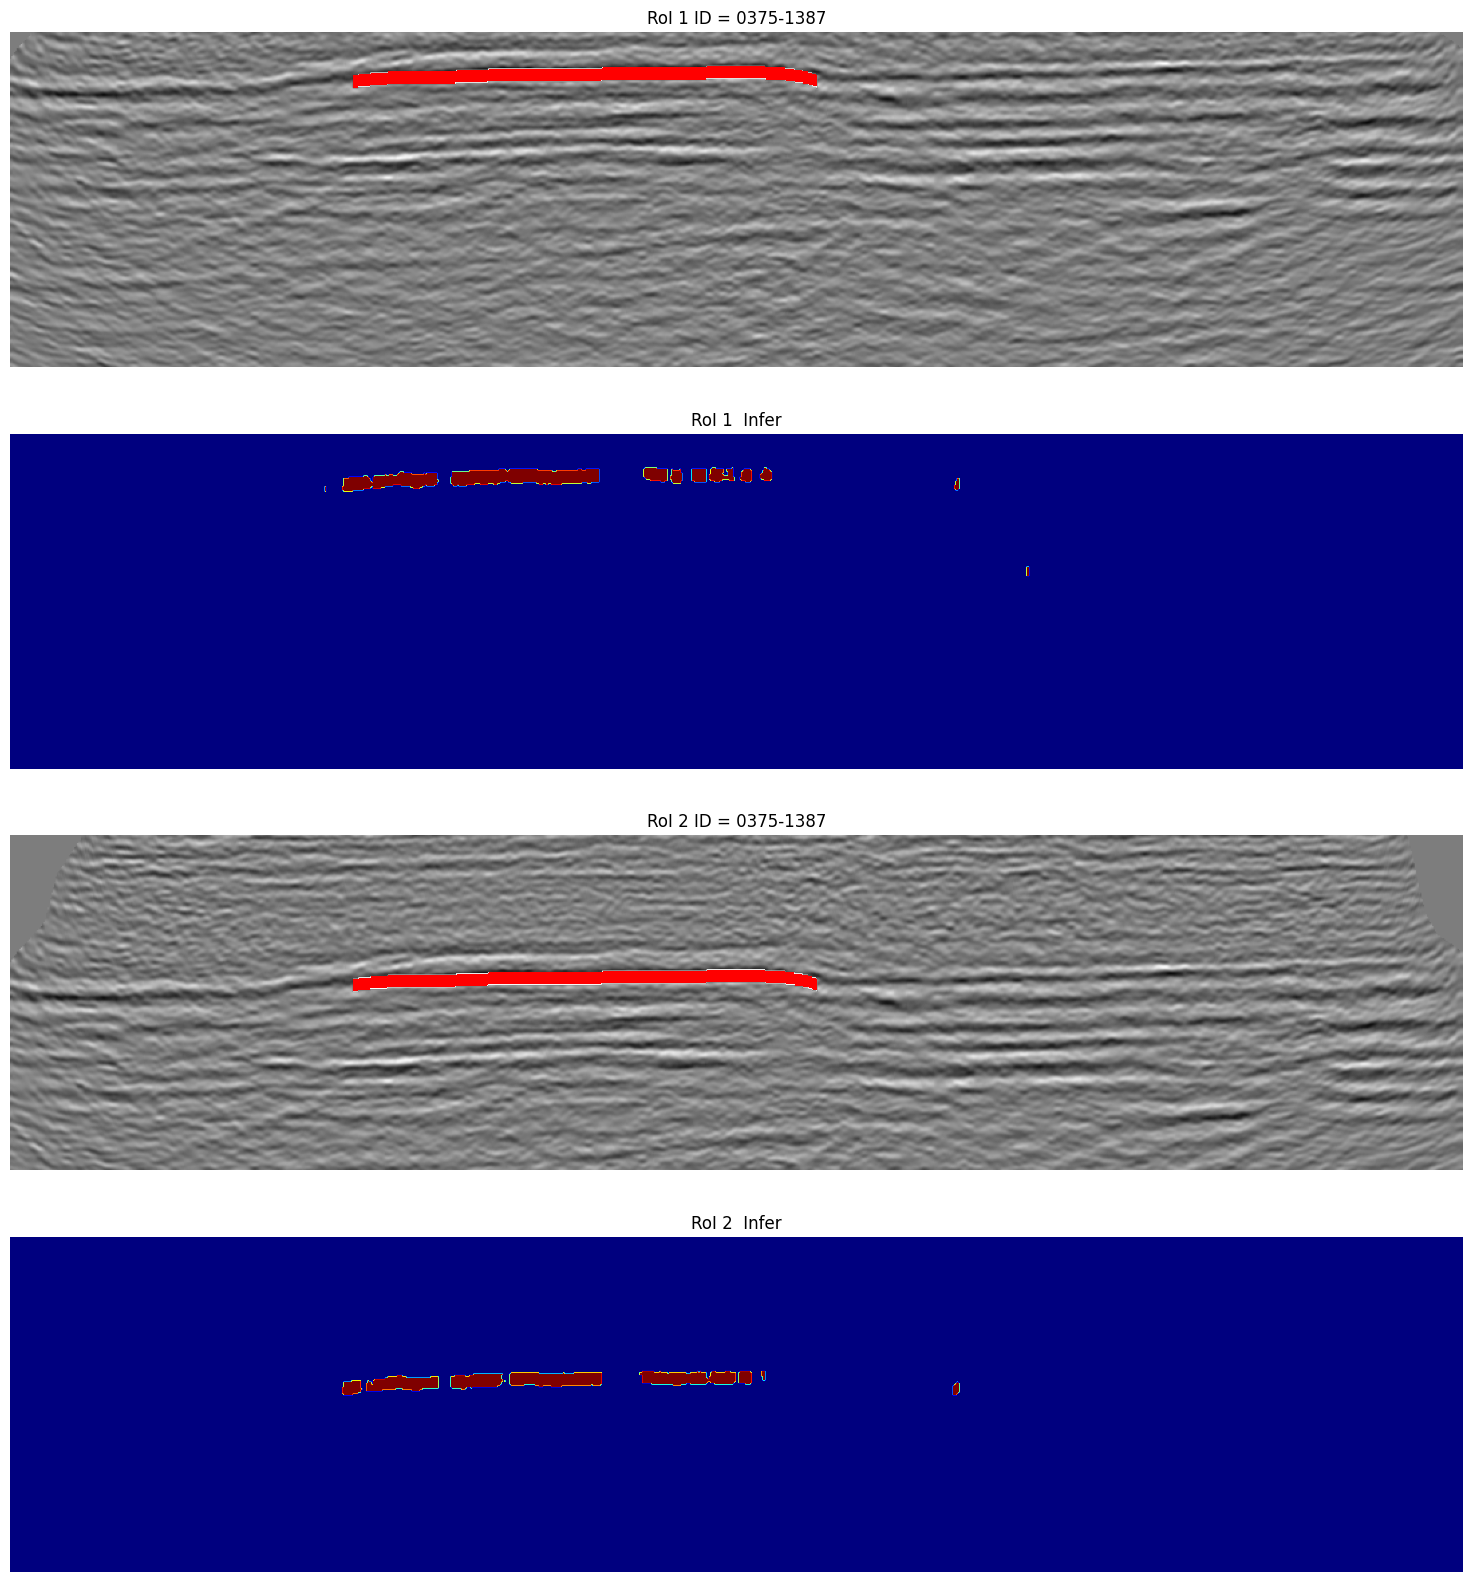

462/462 [==============================] - 245s 531ms/step - loss: 0.3935 - val_loss: 0.3707 - lr: 1.0000e-03
Epoch 12/2000
462/462 [==============================] - ETA: 0s - loss: 0.3295
Epoch 12: val_loss improved from 0.37075 to 0.28997, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 244s 524ms/step - loss: 0.3295 - val_loss: 0.2900 - lr: 1.0000e-03
Epoch 13/2000
462/462 [==============================] - ETA: 0s - loss: 0.2701
Epoch 13: val_loss improved from 0.28997 to 0.25444, saving model to 2D/GPT/gvca/checkpoint_ 2024-03-0031-15-11-33/model/WeightTrained-2024-03-0031-15-11-33.cpk
462/462 [==============================] - 241s 523ms/step - loss: 0.2701 - val_loss: 0.2544 - lr: 9.9999e-04
Epoch 14/2000
419/462 [==========================>...] - ETA: 19s - loss: 0.2561

In [ ]:
#Cria o diretorio de escrita
dt = time.localtime()

strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

cfg.output_paths.out_directory = '2D' + '/GPT/' + dataset_name  + "/checkpoint_ " + strinstante +  "/" + 'model'
if not os.path.exists(cfg.output_paths.out_directory):
    os.makedirs(cfg.output_paths.out_directory)



weights_savename = "WeightTrained-" + strinstante
trained_model, history = model_train(x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val, 
                                     NUMBER_SEQUENCES,
                                     model, 
                                     weights_savename,
                                     cfg.output_paths.out_directory,
                                     cfg.model_config.batch_size,
                                     attrListTest)
modelName = cfg.output_paths.out_directory + '/' + weights_savename + ".cpk"

In [ ]:
modelBest = AlineGPT(num_classes=2,
                 embed_dim=192, 
                 depth=3,
                 mlp_ratio=4.,
                 num_heads=6
                )

modelBest.built = True
modelBest.load_weights(modelName)
modelBest.summary()

In [ ]:
print('TEST METRICS')
testing = Testing2DGPT(
    test_data=attrListTest,
    model=modelBest,
    save_dir=cfg.output_paths.out_directory,
    cfg=cfg,
    batchsize=cfg.model_config.batch_size,
)
testing.inference()
testing.save_metrics()
testing.save_metrics_filtered()

In [ ]:
outputdir = cfg.output_paths.out_directory + '/new_plot/'

for view in test_data:
    ID = view.id
    segy_path = view.file_path
    gas_json = view.gas_horizons
    segy_path2D_json = view.label_file_path
    
    line_2D = segy_loader(segy_path)
    shift = line_2D.twt[0]
    for i in range(len(line_2D.twt)):
        line_2D.twt.values[i] = line_2D.twt.values[i] - shift

    segy_infe_path2D = cfg.output_paths.out_directory + '/Sgy_Inference/' +  'INFERENCE_' + ID + '.sgy'
    cube_infe2D = segy_loader(segy_infe_path2D)
    shift = cube_infe2D.twt[0]
    
    for i in range(len(cube_infe2D.twt)): 
        cube_infe2D.twt.values[i] = cube_infe2D.twt.values[i] - shift
    
    plot_2D_visualization(line_2D, cube_infe2D, outputdir, 900, 1650, segy_path2D_json)

In [ ]:
cfg.output_paths.out_directory